In [6]:
import metmhn.simulations as simul
import metmhn.Utilityfunctions as utils
import pandas as pd
import numpy as np
import jax as jax
from jax import numpy as jnp
import jax.random as jrp
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

rng = np.random.default_rng(seed=42)
key = jrp.PRNGKey(43000)

Read in the metMHN, learned on the reduced LUAD-dataset in `examples/data_analysis.pynb`:

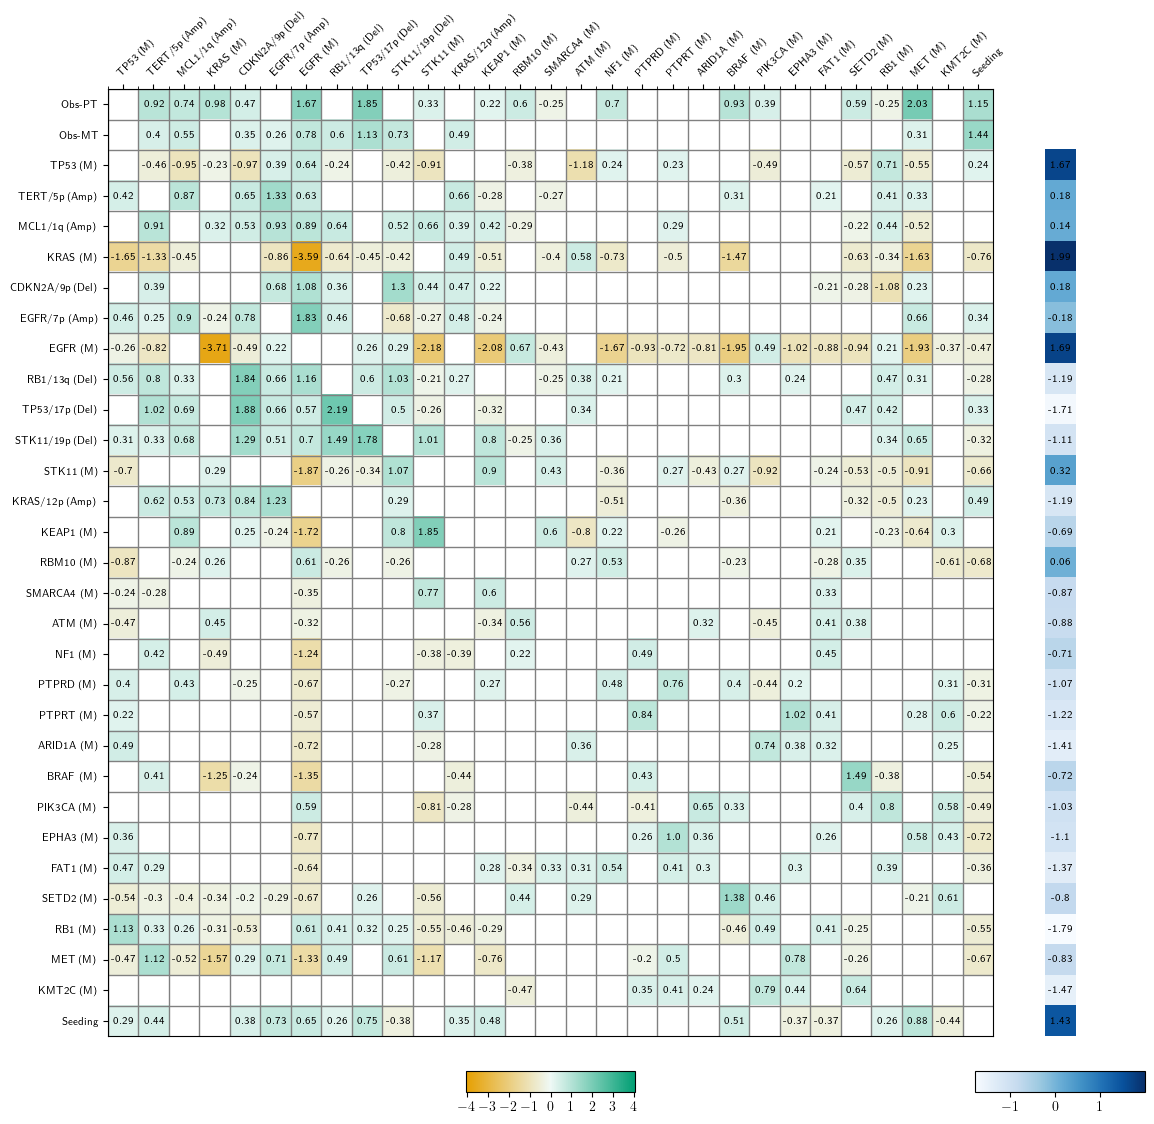

In [7]:
params = pd.read_csv("../results/luad/luad_g14_cv_20muts_8cnvs.csv", index_col=0)
d_p = jnp.array(params.iloc[0,:].to_numpy())
d_m = jnp.array(params.iloc[1, :].to_numpy())
th = jnp.array(params.iloc[2:,:].to_numpy())
events = params.columns
n = th.shape[1]
fig, (ax1, ax2) = plt.subplots(1,2, sharey="col", figsize=(23,15),
                                gridspec_kw={'width_ratios': [n, 1], "wspace": -0.6})
utils.plot_theta(ax1, ax2, params.to_numpy(), events, alpha=0.2, verbose=True, font_size=7.5)
plt.show()

Calculate $P(t_{mut} < t_{seed}| met[mut] = 1)$ i.e. the probability that a mutation happend prior to the seeding for both primary tumors and metastases:

In [8]:
mut_ps, mut_total_prim, mut_total_met = simul.p_any_mut_pre_seed(np.array(th), np.array(d_p), np.array(d_m), 50000, rng)

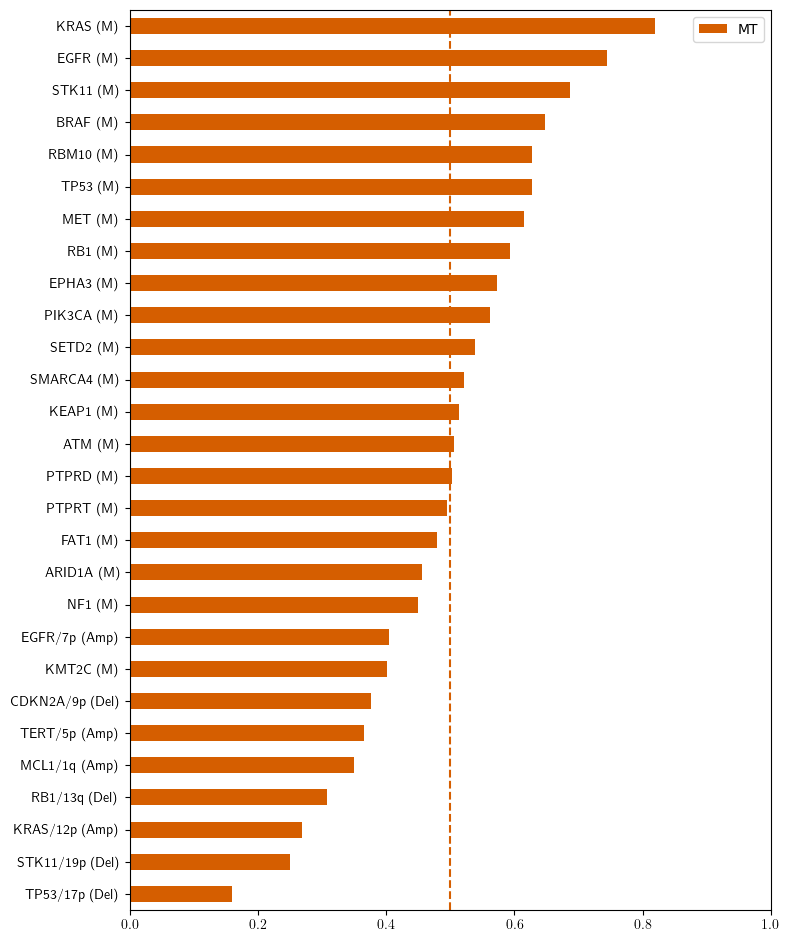

In [9]:
psp = pd.DataFrame(np.column_stack((mut_ps/mut_total_prim, mut_ps/mut_total_met)), 
                  index=events[:-1], columns=["PT", "MT"])
psp.sort_values(by=["MT"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))

plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["MT"].plot(kind="barh", ax=ax, color="#D55E00")
ax.legend()

Simulate synthetic data using Gillespie's algorithm and plot the marginal event frequencies:

In [10]:
key, sub_key = jrp.split(key)
dat = np.array(simul.simulate_dat_jax(jnp.array(th), jnp.array(d_p), jnp.array(d_m), 10000, sub_key))
dat_prim_nomet = dat[dat[:,-2]==0,:-1]
dat_coupled = dat[dat[:,-2]==1,:-1]
dat_pt_first = dat[dat[:, -1] != 2, :]

In [11]:
n_mut = (th.shape[0]-1)
n_tot = n_mut + 1
arr = dat_coupled * np.array([1,2]*n_mut+[1])
arr = arr @ (np.diag([1,0]*n_mut+[1]) + np.diag([1,0]*n_mut, -1))

counts = np.zeros((4, n_tot))
for i in range(0,2*n_tot,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
        ["NM ("+str(dat_prim_nomet.shape[0])+")"],
        ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
counts = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
counts

Coupled (6245)                   NM (3755)
                    PT-Private MT-Private Shared   Present
TP53 (M)                  0.08       0.15   0.39      0.30
TERT/5p (Amp)             0.10       0.21   0.22      0.27
MCL1/1q (Amp)             0.12       0.21   0.20      0.27
KRAS (M)                  0.08       0.04   0.26      0.38
CDKN2A/9p (Del)           0.10       0.20   0.19      0.23
EGFR/7p (Amp)             0.08       0.20   0.19      0.15
EGFR (M)                  0.08       0.06   0.22      0.30
RB1/13q (Del)             0.09       0.15   0.10      0.13
TP53/17p (Del)            0.07       0.19   0.07      0.13
STK11/19p (Del)           0.08       0.15   0.08      0.12
STK11 (M)                 0.05       0.04   0.11      0.13
KRAS/12p (Amp)            0.04       0.13   0.06      0.06
KEAP1 (M)                 0.04       0.06   0.07      0.07
RBM10 (M)                 0.05       0.04   0.06      0.15
SMARCA4 (M)               0.03       0.04   0.04      0.03
ATM (M)                   0.02       0.03   0.04      0.05
NF1 (M)                   0.03       0.04   0.03      0.05
PTPRD (M)                 0.03       0.03   0.03      0.04
PTPRT (M)                 0.02       0.03   0.03      0.04
ARID1A (M)                0.02       0.04   0.03      0.03
BRAF (M)                  0.02       0.02   0.03      0.05
PIK3CA (M)                0.02       0.02   0.03      0.06
EPHA3 (M)                 0.03       0.02   0.03      0.05
FAT1 (M)                  0.02       0.03   0.03      0.04
SETD2 (M)                 0.02       0.02   0.03      0.05
RB1 (M)                   0.02       0.02   0.03      0.02
MET (M)                   0.02       0.02   0.02      0.05
KMT2C (M)                 0.02       0.03   0.02      0.03
Seeding                   1.00       0.00   0.00      0.00

Calculate $P(t_{mut} < t_{seed} | prim[mut] = met[mut] = 1)$ ie. the probability that a **shared** mutation between the primary tumor and the metastasis happened prior to the seeding:

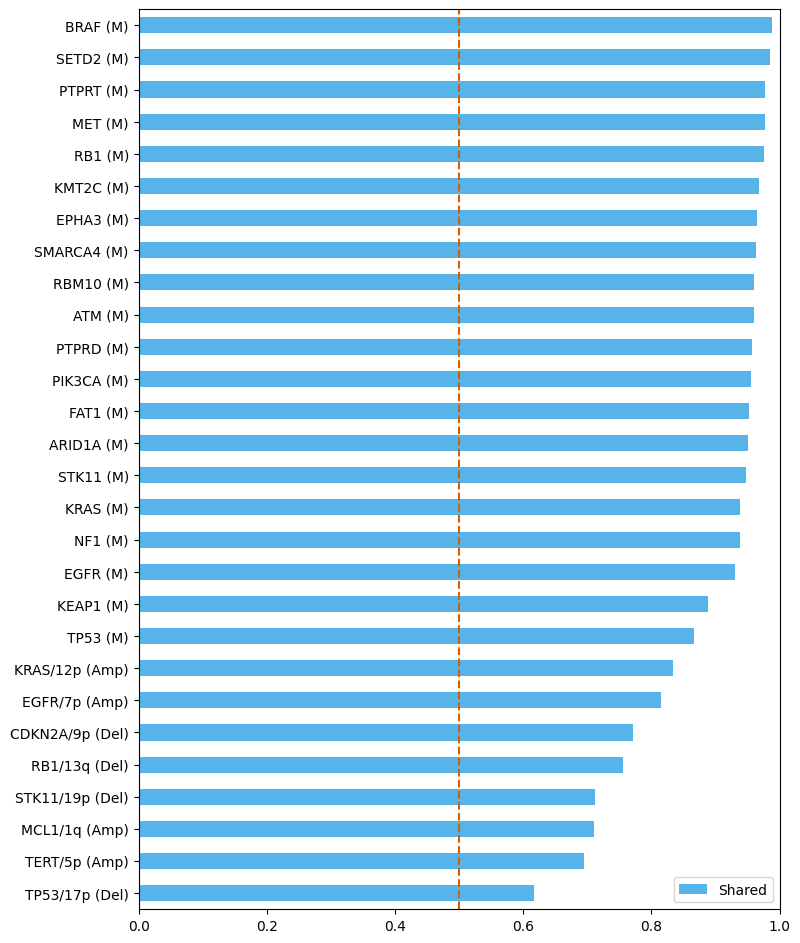

In [12]:
mut_ps, mut_total = simul.p_shared_mut_pre_seed(np.array(th), np.array(d_p), np.array(d_m), 10000, rng)
psp = pd.DataFrame(mut_ps/mut_total, index=events[:-1], columns=["Shared"])
psp.sort_values(by=["Shared"], inplace=True)
fig, ax = plt.subplots(figsize=(8.27, 11.69))
plt.style.use("default")
ax.set_xlim(0,1)
ax.axvline(0.5, color = "#D55E00", linestyle="dashed")
psp["Shared"].plot(kind="barh", color="#56B4E9", ax=ax)
ax.legend()